# Course: Introduction to Modern Data Analysis.

## Homework 1. Topic: Basic classification techniques. Quality metric and cross-validation.

***Author: Ivan Zaputliaev (former TA)***  

---

**Lecturer:** Dmitry Ignatov [dmitrii.ignatov@gmail.com](dmitrii.ignatov@gmail.com)

**TA:** Frank Acquaye [acquayefrank@gmail.com](acquayefrank@gmail.com) & Denis Pozdnyakov [dvpozdnyakov@hse.ru](dvpozdnyakov@hse.ru)

**Q&A:** course chat ([link](https://t.me/+0vRUxEY27sE1OTBi)) or via TA's e-mail

|

**Soft deadline** (up to 10 points): <span style="color:red">***June 12***</span>   
**Hard deadline** (-2 points):  <span style="color:blue">***June 15***</span>    


---




Please send your final notebooks to both teaching assistants (and lecturer in CC) with the **mandatory topic** ***[MDA2024-HW1-Classification-your_full_name]***.

*The dataset source: UCI ML repository (https://archive.ics.uci.edu/ml/datasets)*


In [2]:
import sys

sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

In [3]:
# noinspection PyUnusedLocal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# extended methods
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

sns.set_style('whitegrid')
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Binary classification

### Load data

In [5]:
train = pd.read_csv('spambase_train.csv', sep=',')
test = pd.read_csv('spambase_test.csv', sep=',')
target = 'is_spam'

x_dev, y_dev = train.drop(target, axis=1), train[target]
x_test, y_test = test.drop(target, axis=1), test[target]

train.head(10)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.337,0.000,0.000,0.000,0.337,2.950,7,59,0
1,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1,4,0
2,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.265,0.000,0.000,0.000,1.650,12,33,0
3,0.00,0.00,0.00,0.0,0.00,0.00,1.07,0.00,0.00,0.00,...,0.000,0.000,0.000,0.145,0.437,0.291,1.823,10,62,1
4,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.114,0.114,0.000,0.114,1.645,12,51,0
5,0.00,0.00,0.00,0.0,0.00,0.00,1.78,0.00,0.00,0.00,...,0.000,0.000,0.000,0.586,0.000,0.000,1.307,4,17,0
6,0.51,0.43,0.29,0.0,0.14,0.03,0.00,0.18,0.54,0.62,...,0.012,0.078,0.000,0.443,0.510,0.133,6.590,739,2333,1
7,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.746,0.000,0.000,0.000,0.000,1.687,4,27,0
8,0.00,2.12,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,4.117,47,70,0
9,0.00,1.50,1.50,0.0,0.75,0.00,0.00,0.00,0.75,3.75,...,0.000,0.000,0.000,2.224,1.223,0.000,107.400,412,537,1


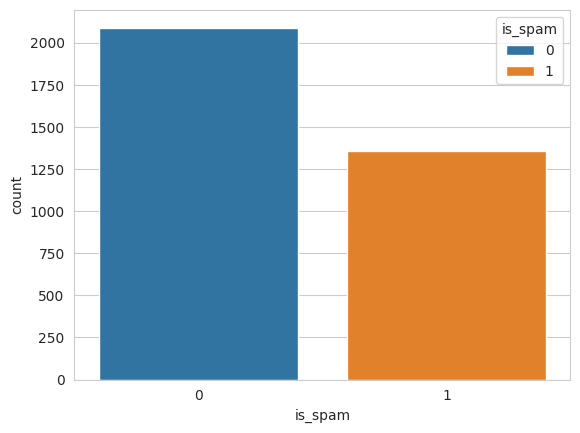

In [6]:
_ = sns.countplot(x=y_dev, hue=y_dev)

### Perform cross-validation to train Logistic Regression

Set cross-validation parameters

In [7]:
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

Set data scaling parameters

In [8]:
scaler = StandardScaler()

Set classifier parameters

In [9]:
clf_params = {'penalty': 'l2', 'C': 0.001}
clf = LogisticRegression(**clf_params, solver='lbfgs', n_jobs=8, random_state=1)

Perform cross-validation to calculate model's quality. Draw the ROC-curve to detect overfitting


fold 1 of 5:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.871014       0.965821  0.816495         0.925234      0.730627

fold 2 of 5:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.871014       0.947219  0.818737         0.917808      0.738971

fold 3 of 5:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.857971       0.943745  0.794979          0.92233      0.698529

fold 4 of 5:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.862319       0.940341   0.80167         0.927536      0.705882

fold 5 of 5:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.852174       0.938353  0.785714         0.916667        0.6875


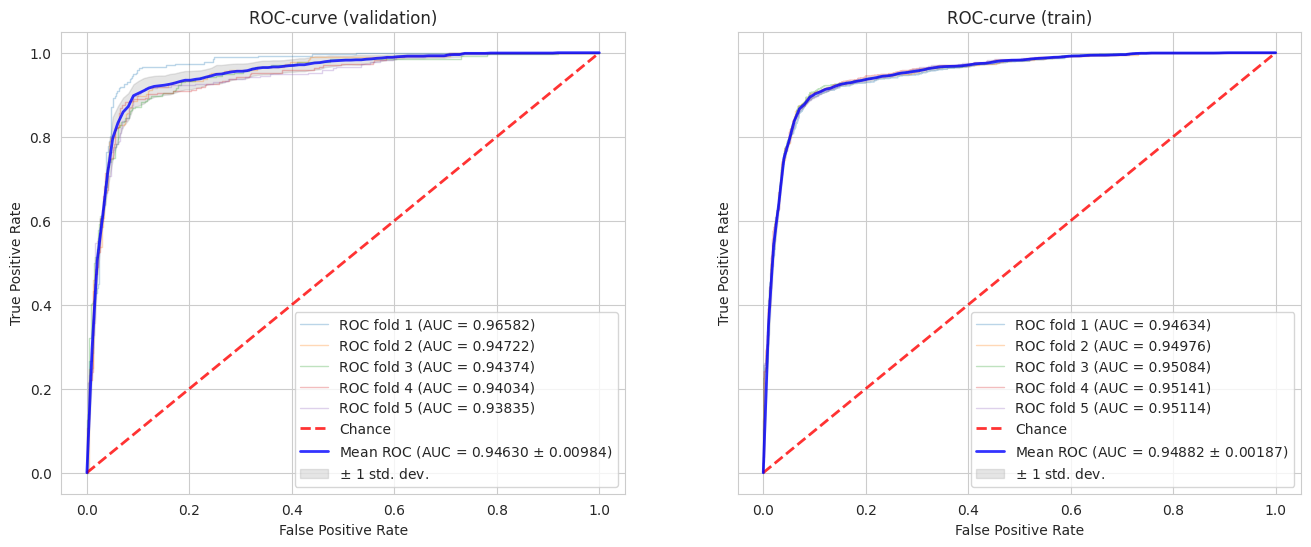

In [10]:
models = []

tprs = [[], []]
aucs = [[], []]
mean_fpr = np.linspace(0, 1, 100)
i = 1

fig, ax = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(16, 6)

for index_train, index_val in cv.split(X=x_dev, y=y_dev):
    # split data to train/validation
    x_train, y_train = x_dev.loc[index_train].values, y_dev.loc[index_train].values
    x_val, y_val = x_dev.loc[index_val].values, y_dev.loc[index_val].values

    # data scaling for metric classifiers
    x_train_scaled = scaler.fit_transform(x_train)
    x_val_scaled = scaler.transform(x_val)

    # train model
    model = clf.fit(x_train_scaled, y_train)
    models.append(model)  # save trained models

    # make prediction and calculate model's quality
    y_val_pred = model.predict(x_val_scaled)  # predicted labels
    y_val_pred_proba = model.predict_proba(x_val_scaled)[:, 1]  # predicted probability of being from class 1

    y_val_pred_quality = pd.DataFrame({'accuracy': accuracy_score(y_val, y_val_pred),
                                       'roc_auc_score': roc_auc_score(y_val, y_val_pred_proba),
                                       'f1_score': f1_score(y_val, y_val_pred),
                                       'precision_score': precision_score(y_val, y_val_pred),
                                       'recall_score': recall_score(y_val, y_val_pred)}, index=[0])
    print()
    print(f'fold {i:d} of {n_splits:d}:')
    print(y_val_pred_quality)

    # calculate ROC-AUC
    # validation
    fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
    tprs[0].append(np.interp(mean_fpr, fpr, tpr))
    tprs[0][-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs[0].append(roc_auc)
    _ = ax[0].plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i:d} (AUC = {roc_auc:0.5f})')

    # train
    fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train_scaled)[:, 1])
    tprs[1].append(np.interp(mean_fpr, fpr, tpr))
    tprs[1][-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs[1].append(roc_auc)
    _ = ax[1].plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i:d} (AUC = {roc_auc:0.5f})')

    i += 1

# plot ROC-curve
for i in range(2):
    _ = ax[i].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs[i], axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs[i])
    _ = ax[i].plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:0.5f} $\pm$ {std_auc:0.5f})', lw=2,
                   alpha=.8)

    std_tpr = np.std(tprs[i], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    _ = ax[i].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    _ = ax[i].set_xlim([-0.05, 1.05])
    _ = ax[i].set_ylim([-0.05, 1.05])
    _ = ax[i].set_xlabel('False Positive Rate')
    _ = ax[i].set_ylabel('True Positive Rate')
    _ = ax[i].legend(loc='lower right')

_ = ax[0].set_title('ROC-curve (validation)')
_ = ax[1].set_title('ROC-curve (train)')
plt.show()

Look at LR coefficients and analyse results

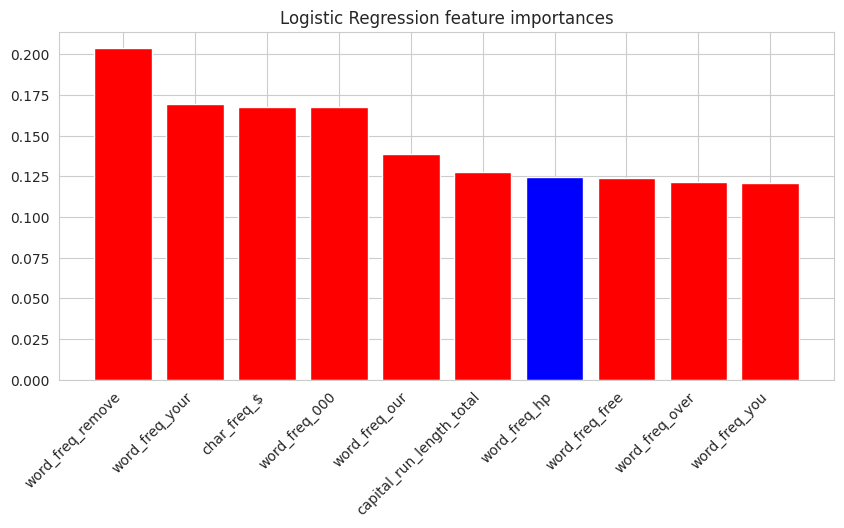

In [11]:
i = 0
lr_feature_importance = pd.DataFrame({'feature': x_dev.columns,
                                      'coeff': models[i].coef_[0], 'abs(coeff)': np.abs(models[i].coef_[0])})
lr_feature_importance.sort_values('abs(coeff)', ascending=False).head(10)

coefs = lr_feature_importance['coeff'].values
color = np.array(['red' if c > 0 else 'blue' for c in coefs])
coefs = np.abs(coefs)
indices = np.argsort(coefs)[::-1]

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plt.title('Logistic Regression feature importances')
plt.bar(range(10), coefs[indices[:10]], color=color[indices[:10]], align='center')
plt.xticks(range(10), x_dev.columns[indices[:10]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)
plt.show()

Plot probabilities distribution for the validation data from last CV iteration of being from "spam" class

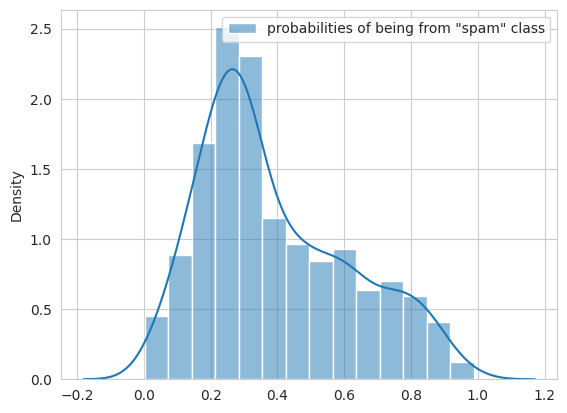

In [12]:
model = models[-1]
y_val_pred_proba = model.predict_proba(x_val_scaled)[:, 1]

_ = sns.histplot(y_val_pred_proba, kde=True, stat='density', kde_kws=dict(cut=3),
                 label='probabilities of being from "spam" class')
_ = plt.legend()
plt.show()

Show confusion matrix for LR prediction

Confusion matrix:
[[401  17]
 [ 85 187]]


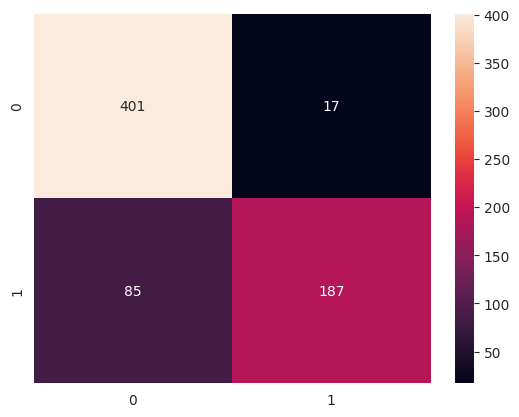

In [13]:
y_val_pred = model.predict(x_val_scaled)
print('Confusion matrix:')
confusion_matrix_df = confusion_matrix(y_val, y_val_pred)
print(confusion_matrix_df)
_ = sns.heatmap(confusion_matrix_df, annot=True, fmt='.10g')

---
### Task 1 (3 points)

Comparing the ROC curves of the training set and the validation set can help. The size of the gap between the training and validation metrics is an indicator of overfitting when the gap is large, and indicates underfitting when there is no gap. Everything in between is subject to interpretation, but a good model should produce a small gap.

Measuring the gap between the training and validation ROC curves should be done by measuring the area between the curves. Keep in mind that the difference between the AUCs does not compute the same quantities.




fold 1 of 3:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0   0.85913       0.953984  0.793893         0.936937      0.688742

fold 2 of 3:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.876522       0.954773  0.822943         0.945559      0.728477

fold 3 of 3:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.825217       0.928929  0.741977         0.886503      0.637969


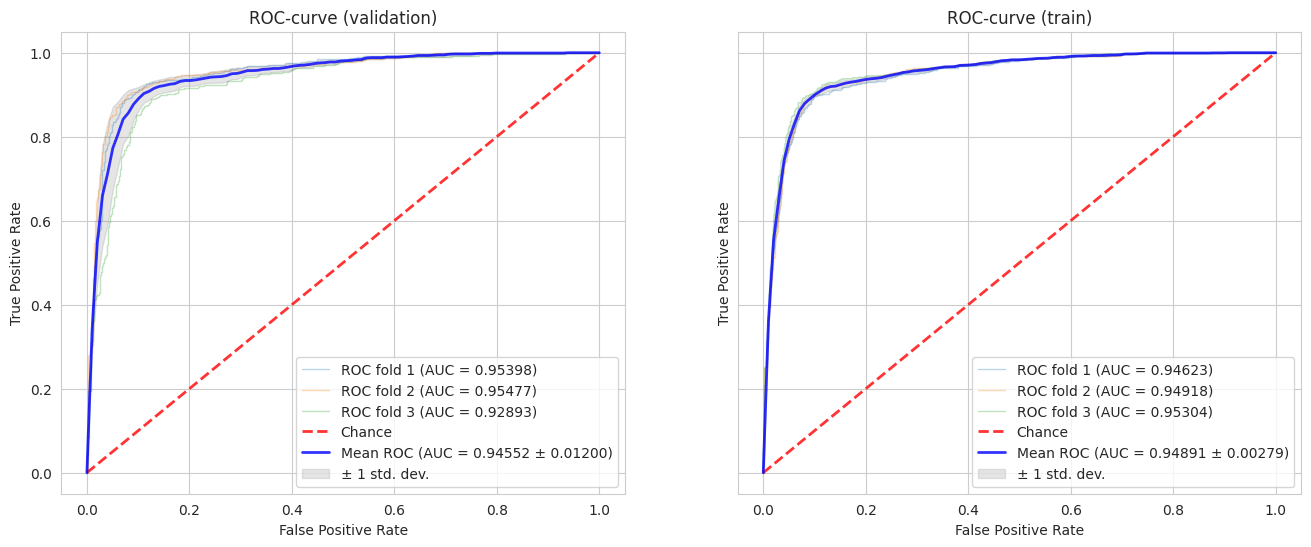


fold 1 of 5:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0   0.86087        0.95431  0.794872         0.944162      0.686347

fold 2 of 5:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0   0.87971        0.95962  0.828157         0.947867      0.735294

fold 3 of 5:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.884058       0.949365  0.836066         0.944444          0.75

fold 4 of 5:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.849275       0.941722  0.785124         0.896226      0.698529

fold 5 of 5:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.846377       0.930226  0.780083         0.895238      0.691176


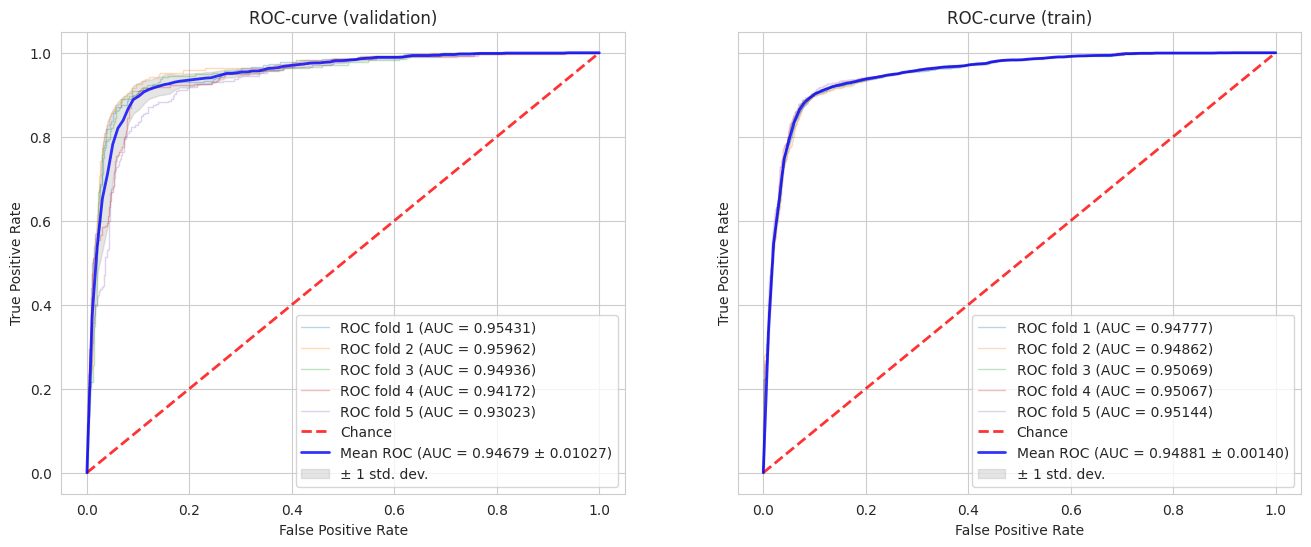


fold 1 of 10:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.866667       0.963704  0.801724         0.958763      0.688889

fold 2 of 10:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0   0.86087        0.94663       0.8         0.923077      0.705882

fold 3 of 10:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.875362       0.948459   0.82449         0.926606      0.742647

fold 4 of 10:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.895652       0.970342   0.85124         0.971698      0.757353

fold 5 of 10:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.866667       0.939417  0.806723         0.941176      0.705882

fold 6 of 10:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.901449       0.958451     0.864         0.947368      0.794118

fold 7 of 10:
   accuracy  roc_auc_score  f1_score  precision_score  recall_score
0  0.869565

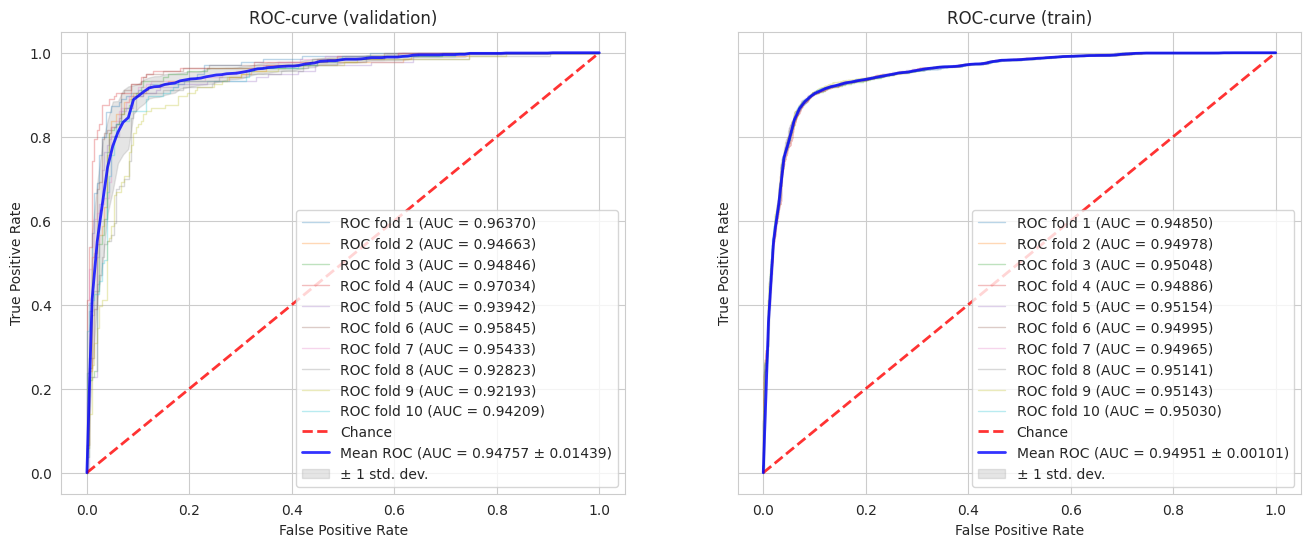

Overfitting Results:
   n_splits  mean_overfitting
0         3          0.003587
1         5          0.002790
2        10          0.002832

Stability Results:
   n_splits   std_auc
0         3  0.012001
1         5  0.010271
2        10  0.014395

Maximum Overfitting:
n_splits            3.000000
mean_overfitting    0.003587
Name: 0, dtype: float64

Minimum Overfitting:
n_splits            5.00000
mean_overfitting    0.00279
Name: 1, dtype: float64

Maximum Stability:
n_splits    5.000000
std_auc     0.010271
Name: 1, dtype: float64

Minimum Stability:
n_splits    10.000000
std_auc      0.014395
Name: 2, dtype: float64


In [14]:
"""
Try 3 different values of n_splits and analyse overfitting and stability
Find n_splits values with maximum and minimum overfitting
Find n_splits values with maximum and minimum stability
"""

# clf, x_dev, y_dev are already defined

n_splits_list = [3, 5, 10]
results = {}

for n_splits in n_splits_list:
    models = []
    tprs = [[], []]
    aucs = [[], []]
    mean_fpr = np.linspace(0, 1, 100)
    i = 1

    cv = StratifiedKFold(n_splits=n_splits)

    fig, ax = plt.subplots(ncols=2, sharey=True)
    fig.set_size_inches(16, 6)

    for index_train, index_val in cv.split(X=x_dev, y=y_dev):
        # Split data to train/validation
        x_train, y_train = x_dev.iloc[index_train].values, y_dev.iloc[index_train].values
        x_val, y_val = x_dev.iloc[index_val].values, y_dev.iloc[index_val].values

        # Data scaling for metric classifiers
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_val_scaled = scaler.transform(x_val)

        # Train model
        model = clf.fit(x_train_scaled, y_train)
        models.append(model)  # Save trained models

        # Make prediction and calculate model's quality
        y_val_pred = model.predict(x_val_scaled)  # Predicted labels
        y_val_pred_proba = model.predict_proba(x_val_scaled)[:, 1]  # Predicted probability of being from class 1

        y_val_pred_quality = pd.DataFrame({'accuracy': accuracy_score(y_val, y_val_pred),
                                           'roc_auc_score': roc_auc_score(y_val, y_val_pred_proba),
                                           'f1_score': f1_score(y_val, y_val_pred),
                                           'precision_score': precision_score(y_val, y_val_pred),
                                           'recall_score': recall_score(y_val, y_val_pred)}, index=[0])
        print()
        print(f'fold {i:d} of {n_splits:d}:')
        print(y_val_pred_quality)

        # Calculate ROC-AUC
        # Validation
        fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
        tprs[0].append(np.interp(mean_fpr, fpr, tpr))
        tprs[0][-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs[0].append(roc_auc)
        ax[0].plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i:d} (AUC = {roc_auc:0.5f})')

        # Train
        fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train_scaled)[:, 1])
        tprs[1].append(np.interp(mean_fpr, fpr, tpr))
        tprs[1][-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs[1].append(roc_auc)
        ax[1].plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i:d} (AUC = {roc_auc:0.5f})')

        i += 1

    results[n_splits] = {
        'models': models,
        'tprs': tprs,
        'aucs': aucs,
        'mean_fpr': mean_fpr
    }

    # Plot ROC-curve
    for j in range(2):
        ax[j].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

        mean_tpr = np.mean(tprs[j], axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs[j])
        ax[j].plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:0.5f} ± {std_auc:0.5f})', lw=2, alpha=.8)

        std_tpr = np.std(tprs[j], axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax[j].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='± 1 std. dev.')

        ax[j].set_xlim([-0.05, 1.05])
        ax[j].set_ylim([-0.05, 1.05])
        ax[j].set_xlabel('False Positive Rate')
        ax[j].set_ylabel('True Positive Rate')
        ax[j].legend(loc='lower right')

    ax[0].set_title('ROC-curve (validation)')
    ax[1].set_title('ROC-curve (train)')
    plt.show()

# Analyze results
overfitting_results = []
stability_results = []

for n_splits in n_splits_list:
    #Calculation the mean difference between train and validation AUC scores to assess overfitting.
    #Calculation the standard deviation of the validation AUC scores to assess stability.
    res = results[n_splits]

    mean_overfitting = np.mean(np.array(res['aucs'][1]) - np.array(res['aucs'][0]))
    std_auc = np.std(res['aucs'][0])

    overfitting_results.append((n_splits, mean_overfitting))
    stability_results.append((n_splits, std_auc))

# Convert results to DataFrame for easy viewing
overfitting_df = pd.DataFrame(overfitting_results, columns=['n_splits', 'mean_overfitting'])
stability_df = pd.DataFrame(stability_results, columns=['n_splits', 'std_auc'])

print("Overfitting Results:")
print(overfitting_df)
print("\nStability Results:")
print(stability_df)

# Find maximum and minimum overfitting
max_overfitting = overfitting_df.loc[overfitting_df['mean_overfitting'].idxmax()]
min_overfitting = overfitting_df.loc[overfitting_df['mean_overfitting'].idxmin()]

# Find maximum and minimum stability
max_stability = stability_df.loc[stability_df['std_auc'].idxmin()]
min_stability = stability_df.loc[stability_df['std_auc'].idxmax()]

print("\nMaximum Overfitting:")
print(max_overfitting)
print("\nMinimum Overfitting:")
print(min_overfitting)
print("\nMaximum Stability:")
print(max_stability)
print("\nMinimum Stability:")
print(min_stability)




```
Overfitting Results:
   n_splits  mean_overfitting
0         3          0.003587
1         5          0.002790
2        10          0.002832

Stability Results:
   n_splits   std_auc
0         3  0.012001
1         5  0.010271
2        10  0.014395

Maximum Overfitting:
n_splits            3.000000
mean_overfitting    0.003587
Name: 0, dtype: float64

Minimum Overfitting:
n_splits            5.00000
mean_overfitting    0.00279
Name: 1, dtype: float64

Maximum Stability:
n_splits    5.000000
std_auc     0.010271
Name: 1, dtype: float64

Minimum Stability:
n_splits    10.000000
std_auc      0.014395
Name: 2, dtype: float64
```



In [15]:
"""
Compare different values of Logistic Regression hyperparameters using cross-validation.
Try different values for: penalty, C, class_weight
Find the best parameters according to F1-score

penalty = ['l1', 'l2']
C = [1.0, 10.0, 0.01, 0.0, 0.001]
class_weight = ['balanced', None]
"""

# the parameter grid
param_grid = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [1.0, 10.0, 0.01, 0.001],
    'logisticregression__class_weight': ['balanced', None]
}

# a pipeline with scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logisticregression', LogisticRegression(solver='liblinear'))  # Use 'liblinear' solver to support 'l1' penalty
])

scorer = make_scorer(f1_score)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scorer, cv=cv, n_jobs=-1)
grid_search.fit(x_dev, y_dev)

#  here are the best parameters and the corresponding F1-score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1-Score:", best_f1_score)

results = pd.DataFrame(grid_search.cv_results_)
print(results)



Best Parameters: {'logisticregression__C': 10.0, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l1'}
Best F1-Score: 0.9098277070234623
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.396003      0.042931         0.013332        0.003669   
1        0.161594      0.019920         0.011234        0.003784   
2        0.363123      0.096152         0.009602        0.002723   
3        0.163380      0.035874         0.011202        0.004036   
4        1.524846      0.699736         0.010699        0.004208   
5        0.132391      0.009112         0.008248        0.000295   
6        1.267846      0.511383         0.007361        0.000297   
7        0.142141      0.019183         0.008023        0.000284   
8        0.032803      0.002648         0.007759        0.000611   
9        0.043644      0.005000         0.007681        0.000268   
10       0.030351      0.002021         0.007451        0.000477   
11       0.03917

Best Parameters: {'logisticregression__C': 10.0, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l1'}     
Best F1-Score: 0.9094229579678768

In [16]:
"""
Train a model with the best parameters on the whole training dataset.
Analyse overfitting using the test data. Is it lower or bigger, comparing to validation case?
"""

best_params = {'C': 10.0, 'class_weight': 'balanced', 'penalty': 'l1'}

clf = LogisticRegression(solver='liblinear', **best_params)
scaler = StandardScaler()

# Scale training data
x_train_scaled = scaler.fit_transform(x_dev)

# Train on the whole training dataset w/o cv
model = clf.fit(x_train_scaled, y_dev)

# Scale test data
x_test_scaled = scaler.transform(x_test)

y_test_pred = model.predict(x_test_scaled)
y_test_pred_proba = model.predict_proba(x_test_scaled)[:, 1]

# Evaluation based on metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred))

print("Test Accuracy:", test_accuracy)
print("Test F1-Score:", test_f1_score)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test ROC AUC:", test_roc_auc)

print("Cross-validated F1-Score:", best_f1_score)
print("Test F1-Score:", test_f1_score)

# overfitting analysis
# comparing the F1-score from the CV (best F1-score) with the F1-score on the test set.
overfitting = best_f1_score - test_f1_score
if overfitting > 0:
    print(f"The model is overfitting. The F1-score difference between cross-validation and test is {overfitting:.4f}.")
else:
    print(f"The model is not overfitting. The F1-score difference between cross-validation and test is {overfitting:.4f}.")


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       697
           1       0.89      0.93      0.91       454

    accuracy                           0.93      1151
   macro avg       0.92      0.93      0.93      1151
weighted avg       0.93      0.93      0.93      1151

Test Accuracy: 0.9287576020851434
Test F1-Score: 0.9114470842332614
Test Precision: 0.8940677966101694
Test Recall: 0.9295154185022027
Test ROC AUC: 0.97202611570039
Cross-validated F1-Score: 0.9098277070234623
Test F1-Score: 0.9114470842332614
The model is not overfitting. The F1-score difference between cross-validation and test is -0.0016.


I'm detecting overfitting by comparing F1-score between training data and test data. If a model performs better on the training data than on the test data, it indicates overfitting.
The model is not overfitting. The F1-score difference between cross-validation and test is -0.0020.

In [17]:
"""
Find 5 most valuable features for "spam" class and 5 for "not spam" class
"""

feature_names = x_dev.columns
coeff = model.coef_[0]

coeff_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coeff
})

#spam
spam_features = coeff_df.nlargest(5, 'coefficient')

#no spam
not_spam_features = coeff_df.nsmallest(5, 'coefficient')

print("Most valuable features for 'spam':")
print(spam_features)

print("\nMost valuable features for 'not spam':")
print(not_spam_features)

print("\n")
print("\n")
print("\n")

"""
Find 10 most and 10 least "spam" object in test data and print them
"""

# probabilities for the test set
y_test_pred_proba = model.predict_proba(x_test_scaled)[:, 1]

# test data and predicted probas
test_df = pd.DataFrame(x_test, columns=feature_names)
test_df['probability'] = y_test_pred_proba
test_df['true_label'] = y_test.values

# Find 10 most "spam" objects
most_spam = test_df.nlargest(10, 'probability')

# Find 10 least "spam" objects
least_spam = test_df.nsmallest(10, 'probability')

print("10 most 'spam' objects in test data:")
print(most_spam)

print("\n10 least 'spam' objects in test data:")
print(least_spam)




Most valuable features for 'spam':
                       feature  coefficient
3                 word_freq_3d     2.629424
55  capital_run_length_longest     2.101210
52                 char_freq_$     1.260404
6             word_freq_remove     1.004851
15              word_freq_free     0.953686

Most valuable features for 'not spam':
             feature  coefficient
26  word_freq_george   -20.102679
40      word_freq_cs    -7.548456
24      word_freq_hp    -2.364004
28     word_freq_lab    -2.311444
30  word_freq_telnet    -2.276429






10 most 'spam' objects in test data:
      word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
275             0.00               0.00           0.00         19.16   
489             0.00               0.00           0.00         19.73   
1033            1.24               0.00           0.82          0.00   
695             0.00               0.00           0.00          0.00   
252             0.21               0.10           0.52

In [18]:



"""
How many "spam" object from the test data are not detected by classifier with the best parameters?
How many "not spam" object from the test data are recognized as "spam"?
"""
best_params = {'C': 10.0, 'class_weight': 'balanced', 'penalty': 'l1'}
clf = LogisticRegression(solver='liblinear', **best_params)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_dev)
model = clf.fit(x_train_scaled, y_dev)
x_test_scaled = scaler.transform(x_test)
y_test_pred = model.predict(x_test_scaled)

# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

# "spam" objects not detected (fn)
spam_not_detected = fn

# "not spam" objects recognized as "spam" (fp)
not_spam_as_spam = fp

print(f"Number of 'spam' objects not detected by classifier: {spam_not_detected}")
print(f"Number of 'not spam' objects recognized as 'spam': {not_spam_as_spam}")



Number of 'spam' objects not detected by classifier: 32
Number of 'not spam' objects recognized as 'spam': 50


In [19]:
"""
Try all previous steps without data scaling
* Show how quality on test data changed
* Show how most valuable features changed
* Show how "spam" and "not spam" objects changed
* Show how probabilities distribution changed
"""

best_params = {'C': 10.0, 'class_weight': 'balanced', 'penalty': 'l1'}
clf = LogisticRegression(solver='liblinear', **best_params)
model = clf.fit(x_dev, y_dev)
y_test_pred = model.predict(x_test)
y_test_pred_proba = model.predict_proba(x_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print("Evaluation Metrics without Data Scaling:")
print("Test Accuracy:", test_accuracy)
print("Test F1-Score:", test_f1_score)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test ROC AUC:", test_roc_auc)

print("\nClassification Report on Test Data (without scaling):")
print(classification_report(y_test, y_test_pred))

# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

# "spam" objects not detected (fn)
spam_not_detected = fn

# "not spam" objects recognized as "spam" (fp)
not_spam_as_spam = fp

print(f"Number of 'spam' objects not detected by classifier: {spam_not_detected}")
print(f"Number of 'not spam' objects recognized as 'spam': {not_spam_as_spam}")


Evaluation Metrics without Data Scaling:
Test Accuracy: 0.9287576020851434
Test F1-Score: 0.9114470842332614
Test Precision: 0.8940677966101694
Test Recall: 0.9295154185022027
Test ROC AUC: 0.9723105316049274

Classification Report on Test Data (without scaling):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       697
           1       0.89      0.93      0.91       454

    accuracy                           0.93      1151
   macro avg       0.92      0.93      0.93      1151
weighted avg       0.93      0.93      0.93      1151

Number of 'spam' objects not detected by classifier: 32
Number of 'not spam' objects recognized as 'spam': 50


In [20]:
feature_names = x_dev.columns
coeff = model.coef_[0]
coeff_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coeff
})
spam_features = coeff_df.nlargest(5, 'coefficient')
not_spam_features = coeff_df.nsmallest(5, 'coefficient')

print("\nMost valuable features for 'spam' (without scaling):")
print(spam_features)

print("\nMost valuable features for 'not spam' (without scaling):")
print(not_spam_features)



Most valuable features for 'spam' (without scaling):
             feature  coefficient
52       char_freq_$     5.175109
6   word_freq_remove     2.547900
22     word_freq_000     2.430713
3       word_freq_3d     1.748285
19  word_freq_credit     1.329759

Most valuable features for 'not spam' (without scaling):
                 feature  coefficient
40          word_freq_cs   -16.421647
26      word_freq_george    -8.032119
30      word_freq_telnet    -4.841245
28         word_freq_lab    -3.629966
47  word_freq_conference    -3.626553


In [21]:
test_df = pd.DataFrame(x_test, columns=feature_names)
test_df['probability'] = y_test_pred_proba
test_df['true_label'] = y_test.values

most_spam = test_df.nlargest(10, 'probability')

least_spam = test_df.nsmallest(10, 'probability')

print("\n10 most 'spam' objects in test data (without scaling):")
print(most_spam)

print("\n10 least 'spam' objects in test data (without scaling):")
print(least_spam)



10 most 'spam' objects in test data (without scaling):
      word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
275             0.00               0.00           0.00         19.16   
489             0.00               0.00           0.00         19.73   
1033            1.24               0.00           0.82          0.00   
695             0.00               0.00           0.00          0.00   
252             0.21               0.10           0.52          0.00   
696             0.00               0.00           0.46          0.00   
424             0.00               0.00           0.00          0.00   
286             0.51               0.17           0.51          0.00   
332             0.08               0.08           0.76          0.00   
508             0.08               0.08           0.76          0.00   

      word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
275            0.18            0.00              0.18                0.00 

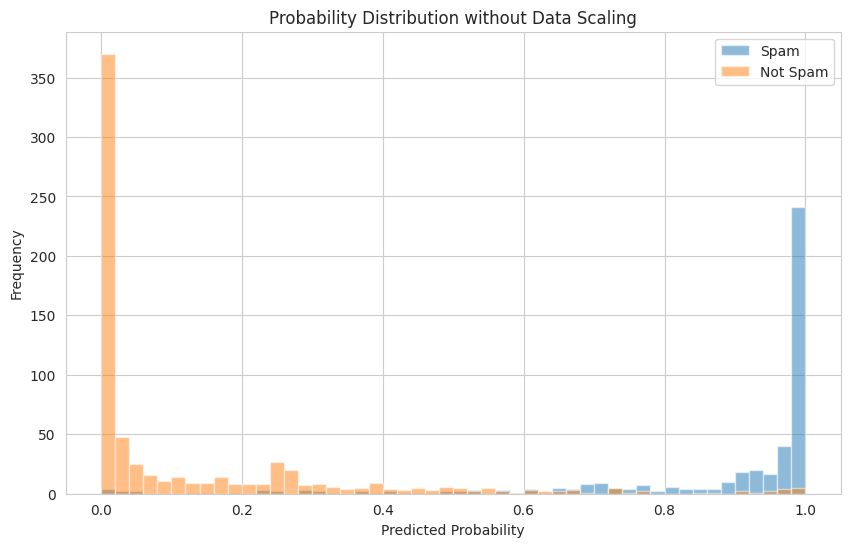

In [22]:

plt.figure(figsize=(10, 6))
plt.hist(y_test_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Spam')
plt.hist(y_test_pred_proba[y_test == 0], bins=50, alpha=0.5, label='Not Spam')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution without Data Scaling')
plt.legend(loc='best')
plt.show()


---
### Perform GridSearchCV to train Naive Bayes classifier

In [23]:
# set data scaler
scaler = MinMaxScaler((0, 1))

# set classifier parameters
clf_params = {'alpha': np.linspace(0, 1, 10),
              'fit_prior': [True, False]}
clf = MultinomialNB()

# set scorer
scorer_ = 'f1'

# set CV parameters
cv = 5

# set GridSearch parameters
grcv = GridSearchCV(estimator=clf, param_grid=clf_params, scoring=scorer_, cv=cv, return_train_score=True, n_jobs=8,
                    verbose=1)

# set Pipeline parameters
pipeline = Pipeline(steps=[('scaling', scaler), ('parameters tuning', grcv)])

# launch pipeline with scaling followed by cross-validation with parameters tuning
_ = pipeline.fit(x_dev.values, y_dev.values)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


### Find the best NB parameters

In [24]:
print(f'NB classifier gets best {str(scorer_)}: {grcv.best_score_:f} with parameters: {str(grcv.best_params_)}')

NB classifier gets best f1: 0.854742 with parameters: {'alpha': 0.1111111111111111, 'fit_prior': True}


### Look at GridSearchCV history

In [25]:
columns_to_drop = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params']
grcv_result = pd.DataFrame(grcv.cv_results_).drop(columns_to_drop, axis=1)
grcv_result.head(10)

,param_alpha,param_fit_prior,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.0,True,0.847870,0.868369,0.876712,0.856574,0.820202,0.853946,0.019539,2,0.856436,0.849123,0.850851,0.858987,0.861401,0.855359,0.004691
1,0.0,False,0.825806,0.840909,0.811912,0.836538,0.816587,0.826351,0.011134,11,0.827284,0.828469,0.832528,0.829053,0.832528,0.829972,0.002163
2,0.111111,True,0.847870,0.870079,0.876712,0.858847,0.820202,0.854742,0.019875,1,0.856154,0.848546,0.848120,0.858987,0.861111,0.854584,0.005342
3,0.111111,False,0.822400,0.841424,0.811232,0.832536,0.813291,0.824177,0.011459,12,0.824464,0.823857,0.829992,0.825410,0.831325,0.827010,0.003050
4,0.222222,True,0.840816,0.867850,0.876712,0.854871,0.813765,0.850803,0.022136,4,0.854599,0.847543,0.847695,0.857427,0.860546,0.853562,0.005205
5,0.222222,False,0.819777,0.836013,0.809969,0.831210,0.810726,0.821539,0.010554,13,0.822504,0.821896,0.828663,0.821798,0.828995,0.824771,0.003324
6,0.333333,True,0.840816,0.867850,0.876712,0.854871,0.813765,0.850803,0.022136,4,0.855022,0.847118,0.847118,0.855865,0.860546,0.853134,0.005260
7,0.333333,False,0.817170,0.836013,0.808709,0.824645,0.810726,0.819452,0.009980,14,0.820229,0.820269,0.827284,0.819659,0.825030,0.822494,0.003082
8,0.444444,True,0.842536,0.867850,0.878431,0.854871,0.811359,0.851009,0.023214,3,0.854879,0.847118,0.846540,0.854156,0.859274,0.852393,0.004873
9,0.444444,False,0.817170,0.834671,0.808709,0.824645,0.809449,0.818929,0.009776,15,0.817967,0.818469,0.825637,0.818362,0.825030,0.821093,0.003472


### Task 2 (2 points)

In [26]:

"""
Find 5 best parameters' combinations for trained GridSearchCV
Show Naive Bayes quality with these parameters
"""

best_combinations = grcv_result.nlargest(5, 'mean_test_score')

print("\n5 Best Parameter Combinations:")
print(best_combinations[['param_alpha', 'param_fit_prior', 'mean_test_score']])

x_test_scaled = scaler.transform(x_test)

for i, row in best_combinations.iterrows():
    params = {'alpha': row['param_alpha'], 'fit_prior': row['param_fit_prior']}
    model = MultinomialNB(**params)
    model.fit(x_dev, y_dev)

    y_test_pred = model.predict(x_test_scaled)
    y_test_pred_proba = model.predict_proba(x_test_scaled)[:, 1]

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1_score = f1_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

    print(f"\nEvaluation Metrics with parameters: {params}")
    print("Test Accuracy:", test_accuracy)
    print("Test F1-Score:", test_f1_score)
    print("Test Precision:", test_precision)
    print("Test Recall:", test_recall)
    print("Test ROC AUC:", test_roc_auc)
    print("Classification Report:")
    print(classification_report(y_test, y_test_pred))



5 Best Parameter Combinations:
  param_alpha param_fit_prior  mean_test_score
2    0.111111            True         0.854742
0         0.0            True         0.853946
8    0.444444            True         0.851009
4    0.222222            True         0.850803
6    0.333333            True         0.850803

Evaluation Metrics with parameters: {'alpha': 0.1111111111111111, 'fit_prior': True}
Test Accuracy: 0.682015638575152
Test F1-Score: 0.3321167883211679
Test Precision: 0.9680851063829787
Test Recall: 0.20044052863436124
Test ROC AUC: 0.9221048041006453
Classification Report:
              precision    recall  f1-score   support

           0       0.66      1.00      0.79       697
           1       0.97      0.20      0.33       454

    accuracy                           0.68      1151
   macro avg       0.81      0.60      0.56      1151
weighted avg       0.78      0.68      0.61      1151


Evaluation Metrics with parameters: {'alpha': 0.0, 'fit_prior': True}
Test Accura

In [27]:
"""
Set scorer to roc_auc and repeat experiment
Find 5 best parameters' combinations and show NB quality with this parameters
"""

scaler = MinMaxScaler((0, 1))

clf_params = {'alpha': np.linspace(0, 1, 10), 'fit_prior': [True, False]}
clf = MultinomialNB()

scorer_ = 'roc_auc' #

cv = 5
grcv = GridSearchCV(estimator=clf, param_grid=clf_params, scoring=scorer_, cv=cv, return_train_score=True, n_jobs=8, verbose=1)
pipeline = Pipeline(steps=[('scaling', scaler), ('parameters tuning', grcv)])

_ = pipeline.fit(x_dev.values, y_dev.values)
print(f'NB classifier gets best {str(scorer_)}: {grcv.best_score_:f} with parameters: {str(grcv.best_params_)}')

columns_to_drop = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params']
grcv_result = pd.DataFrame(grcv.cv_results_).drop(columns_to_drop, axis=1)

# Find 5 best parameters' combinations
best_combinations = grcv_result.nlargest(5, 'mean_test_score')

print("\n5 Best Parameter Combinations:")
print(best_combinations[['param_alpha', 'param_fit_prior', 'mean_test_score']])

# show NB quality with this parameters
x_test_scaled = scaler.transform(x_test)

for i, row in best_combinations.iterrows():
    params = {'alpha': row['param_alpha'], 'fit_prior': row['param_fit_prior']}
    model = MultinomialNB(**params)
    model.fit(x_dev, y_dev)

    y_test_pred = model.predict(x_test_scaled)
    y_test_pred_proba = model.predict_proba(x_test_scaled)[:, 1]

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1_score = f1_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

    print(f"\nEvaluation Metrics with parameters: {params}")
    print("Test Accuracy:", test_accuracy)
    print("Test F1-Score:", test_f1_score)
    print("Test Precision:", test_precision)
    print("Test Recall:", test_recall)
    print("Test ROC AUC:", test_roc_auc)
    print("Classification Report:")
    print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
NB classifier gets best roc_auc: 0.957501 with parameters: {'alpha': 0.0, 'fit_prior': True}

5 Best Parameter Combinations:
  param_alpha param_fit_prior  mean_test_score
0         0.0            True         0.957501
1         0.0           False         0.957501
2    0.111111            True         0.956556
3    0.111111           False         0.956556
4    0.222222            True         0.956208

Evaluation Metrics with parameters: {'alpha': 0.0, 'fit_prior': True}
Test Accuracy: 0.6828844483058211
Test F1-Score: 0.33515482695810567
Test Precision: 0.968421052631579
Test Recall: 0.2026431718061674
Test ROC AUC: 0.9224966660135634
Classification Report:
              precision    recall  f1-score   support

           0       0.66      1.00      0.79       697
           1       0.97      0.20      0.34       454

    accuracy                           0.68      1151
   macro avg       0.81      0.60      0.56      11

In [28]:
"""
Create a custom scorer using make_scorer and repeat the experiment. Note: errors_score is an error metric
Show F1 and roc_auc values for 5 best and 5 worst parameters combinations
"""

scaler = MinMaxScaler((0, 1))

clf_params = {'alpha': np.linspace(0, 1, 10), 'fit_prior': [True, False]}
clf = MultinomialNB()

# Create a custom scorer using make_scorer
def errors_score(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)
scorer_ = make_scorer(errors_score, greater_is_better=False)

cv = 5
grcv = GridSearchCV(estimator=clf, param_grid=clf_params, scoring=scorer_, cv=cv, return_train_score=True, n_jobs=8, verbose=1)
pipeline = Pipeline(steps=[('scaling', scaler), ('parameters tuning', grcv)])
_ = pipeline.fit(x_dev.values, y_dev.values)
print(f'NB classifier gets best errors_score: {grcv.best_score_:f} with parameters: {str(grcv.best_params_)}')

columns_to_drop = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params']
grcv_result = pd.DataFrame(grcv.cv_results_).drop(columns_to_drop, axis=1)

best_combinations = grcv_result.nsmallest(5, 'mean_test_score') # smaller values indicate better performance because of custom scorer
worst_combinations = grcv_result.nlargest(5, 'mean_test_score')

print("\n5 Best Parameter Combinations:")
print(best_combinations[['param_alpha', 'param_fit_prior', 'mean_test_score']])

print("\n5 Worst Parameter Combinations:")
print(worst_combinations[['param_alpha', 'param_fit_prior', 'mean_test_score']])

x_test_scaled = scaler.transform(x_test)

def evaluate_model_performance(model, x_test, y_test):
    y_test_pred = model.predict(x_test)
    y_test_pred_proba = model.predict_proba(x_test)[:, 1]

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1_score = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

    return test_f1_score, test_roc_auc

print("\nEvaluation Metrics for 5 Best Parameter Combinations:")
for i, row in best_combinations.iterrows():
    params = {'alpha': row['param_alpha'], 'fit_prior': row['param_fit_prior']}
    model = MultinomialNB(**params)
    model.fit(x_dev, y_dev)
    f1, roc_auc = evaluate_model_performance(model, x_test_scaled, y_test)
    print(f"Parameters: {params}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

print("\nEvaluation Metrics for 5 Worst Parameter Combinations:")
for i, row in worst_combinations.iterrows():
    params = {'alpha': row['param_alpha'], 'fit_prior': row['param_fit_prior']}
    model = MultinomialNB(**params)
    model.fit(x_dev, y_dev)
    f1, roc_auc = evaluate_model_performance(model, x_test_scaled, y_test)
    print(f"Parameters: {params}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
NB classifier gets best errors_score: -0.105507 with parameters: {'alpha': 0.1111111111111111, 'fit_prior': True}

5 Best Parameter Combinations:
   param_alpha param_fit_prior  mean_test_score
19         1.0           False        -0.171014
17    0.888889           False        -0.170145
15    0.777778           False        -0.168986
13    0.666667           False        -0.168406
11    0.555556           False        -0.166957

5 Worst Parameter Combinations:
  param_alpha param_fit_prior  mean_test_score
2    0.111111            True        -0.105507
0         0.0            True        -0.106087
8    0.444444            True        -0.107826
4    0.222222            True        -0.108116
6    0.333333            True        -0.108116

Evaluation Metrics for 5 Best Parameter Combinations:
Parameters: {'alpha': 1.0, 'fit_prior': False}, F1-Score: 0.6694, ROC AUC: 0.9212
Parameters: {'alpha': 0.8888888888888888, 'fit_prior

In [29]:
"""
Find 5 most valuable features for "spam" class and 5 for "not spam" class
Are these features the same as in LR?
"""
# coeff = grcv.best_estimator_.coef_
# ...

feature_names = x_dev.columns
nb_model = grcv.best_estimator_

log_probabilities = nb_model.feature_log_prob_

spam_class_index = np.where(nb_model.classes_ == 1)[0][0]
not_spam_class_index = np.where(nb_model.classes_ == 0)[0][0]

spam_log_probabilities = log_probabilities[spam_class_index]
not_spam_log_probabilities = log_probabilities[not_spam_class_index]

top_spam_indices = np.argsort(spam_log_probabilities)[::-1][:5]
top_not_spam_indices = np.argsort(not_spam_log_probabilities)[::-1][:5]

top_spam_features = [feature_names[i] for i in top_spam_indices]
top_not_spam_features = [feature_names[i] for i in top_not_spam_indices]

print("Top 5 features for 'spam' class:")
print(top_spam_features)

print("\nTop 5 features for 'not spam' class:")
print(top_not_spam_features)


Top 5 features for 'spam' class:
['word_freq_your', 'word_freq_you', 'word_freq_all', 'word_freq_will', 'word_freq_our']

Top 5 features for 'not spam' class:
['word_freq_will', 'word_freq_you', 'word_freq_hp', 'word_freq_your', 'word_freq_all']


For LR:

```
Most valuable features for 'spam':
                       feature  coefficient
3                 word_freq_3d     2.640153
55  capital_run_length_longest     2.104202
52                 char_freq_$     1.260501
6             word_freq_remove     1.004480
15              word_freq_free     0.953330

Most valuable features for 'not spam':
             feature  coefficient
26  word_freq_george   -20.200957
40      word_freq_cs    -7.597578
24      word_freq_hp    -2.365943
28     word_freq_lab    -2.308903
30  word_freq_telnet    -2.285296
```



**They are totally different!**

### Find the best scaler and parameters for k-Nearest Neighbors classifier

In [30]:
# set classifier parameters
clf_params = {'n_neighbors': list(range(1, 6)),
              'p': list(range(1, 3))}
clf = KNeighborsClassifier(n_jobs=1)

# set scorer
scorer_ = 'roc_auc'

# set CV parameters
cv = 5

# set GridSearch parameters
grcv = GridSearchCV(estimator=clf, param_grid=clf_params, scoring=scorer_, cv=cv, return_train_score=True, n_jobs=8,
                    verbose=1)

# set scaler as Pipeline parameter
scaler = Normalizer()

# set Pipeline parameters
pipeline = Pipeline(steps=[('scaling', scaler), ('parameters tuning', grcv)])

# launch the pipeline with scaling followed by cross-validation with parameters tuning
_ = pipeline.fit(x_dev.values, y_dev.values)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Find best kNN parameters

In [31]:
print(f'kNN classifier gets best {str(scorer_)}: {grcv.best_score_:f} with parameters: {str(grcv.best_params_)}')

kNN classifier gets best roc_auc: 0.915130 with parameters: {'n_neighbors': 4, 'p': 1}


### Task 3 (2 points)

In [32]:
"""
Try to obtain the best kNN quality using GridSearchCV with different scalers
Print scaler, parameters and obtained quality
"""

# Set classifier parameters
clf_params = {'n_neighbors': list(range(1, 6)), 'p': list(range(1, 3))}
clf = KNeighborsClassifier(n_jobs=1)

# Set scorer
scorer_ = 'roc_auc'

# Set CV parameters
cv = 5

# Set GridSearch parameters
grcv = GridSearchCV(estimator=clf, param_grid=clf_params, scoring=scorer_, cv=cv, return_train_score=True, n_jobs=8, verbose=1)

scalers = [StandardScaler(), Normalizer(), MinMaxScaler((0,1))]

for scaler in scalers:
    pipeline = Pipeline(steps=[('scaling', scaler), ('parameters tuning', grcv)])
    _ = pipeline.fit(x_dev.values, y_dev.values)

    print(f"\nScaler: {scaler.__class__.__name__}")
    print(f"Best Parameters: {grcv.best_params_}")
    print(f"Best {scorer_} Score: {grcv.best_score_:.6f}")




Fitting 5 folds for each of 10 candidates, totalling 50 fits

Scaler: StandardScaler
Best Parameters: {'n_neighbors': 5, 'p': 1}
Best roc_auc Score: 0.953987
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Scaler: Normalizer
Best Parameters: {'n_neighbors': 4, 'p': 1}
Best roc_auc Score: 0.915130
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Scaler: MinMaxScaler
Best Parameters: {'n_neighbors': 5, 'p': 1}
Best roc_auc Score: 0.946019


In [33]:
"""
Show how kNN quality changes without scaling before training
"""

# Set classifier parameters
clf_params = {'n_neighbors': list(range(1, 6)), 'p': list(range(1, 3))}
clf = KNeighborsClassifier(n_jobs=1)

# Set scorer
scorer_ = 'roc_auc'

# Set CV parameters
cv = 5

# Set GridSearch parameters
grcv = GridSearchCV(estimator=clf, param_grid=clf_params, scoring=scorer_, cv=cv, return_train_score=True, n_jobs=8, verbose=1)

# Pipelinewithout scaling
pipeline = Pipeline(steps=[('parameters tuning', grcv)])

# Launch the pipeline without scaling followed by cross-validation with parameters tuning
_ = pipeline.fit(x_dev.values, y_dev.values)

print(f'kNN classifier gets best {str(scorer_)}: {grcv.best_score_:f} with parameters: {str(grcv.best_params_)}')


Fitting 5 folds for each of 10 candidates, totalling 50 fits
kNN classifier gets best roc_auc: 0.893929 with parameters: {'n_neighbors': 5, 'p': 1}


kNN classifier **with scaling** gets best roc_auc: 0.915130 with parameters: {'n_neighbors': 4, 'p': 1}.   
kNN classifier **without scaling** gets best roc_auc: 0.893929 with parameters: {'n_neighbors': 5, 'p': 1}

### Task 4 (3 points)

In [34]:
"""
Take the best LR, NB and kNN classifiers according to roc_auc on cross-validation.
Compare their quality on the test data.
Which classifier has the best roc_auc score? What are its parameters?
Which classifier has the least false negatives?
Which classifier has the least type-1 errors?
"""
scaler = StandardScaler()
scaler_NB = MinMaxScaler((0, 1))
x_train_scaled = scaler.fit_transform(x_dev)
x_train_scaled_NB = scaler_NB.fit_transform(x_dev)
x_test_scaled = scaler.transform(x_test)
x_test_scaled_NB = scaler_NB.transform(x_test)

lr_param_grid = {'penalty': 'l1', 'C': 10, 'class_weight': 'balanced'}
nb_param_grid = {'alpha': 0.0, 'fit_prior': True}
knn_param_grid = {'n_neighbors': 5, 'p': 1}

best_lr = LogisticRegression(**lr_param_grid, solver='liblinear', n_jobs=8)
best_nb = MultinomialNB(**nb_param_grid)
best_knn = KNeighborsClassifier(**knn_param_grid, n_jobs=1)

# Fit
best_lr.fit(x_train_scaled, y_dev)
best_nb.fit(x_train_scaled_NB, y_dev)
best_knn.fit(x_train_scaled, y_dev)

# ROC AUC
lr_roc_auc = roc_auc_score(y_test, best_lr.predict_proba(x_test_scaled)[:, 1])
nb_roc_auc = roc_auc_score(y_test, best_nb.predict_proba(x_test_scaled_NB)[:, 1])
knn_roc_auc = roc_auc_score(y_test, best_knn.predict_proba(x_test_scaled)[:, 1])

print("ROC AUC Scores:")
print("Logistic Regression:", lr_roc_auc)
print("Naive Bayes:", nb_roc_auc)
print("kNN:", knn_roc_auc)


lr_preds = best_lr.predict(x_test_scaled)
nb_preds = best_nb.predict(x_test_scaled_NB)
knn_preds = best_knn.predict(x_test_scaled)

# confusion matrices
lr_conf_matrix = confusion_matrix(y_test, lr_preds)
nb_conf_matrix = confusion_matrix(y_test, nb_preds)
knn_conf_matrix = confusion_matrix(y_test, knn_preds)

# fn and fp
lr_false_negatives = lr_conf_matrix[1][0]
nb_false_negatives = nb_conf_matrix[1][0]
knn_false_negatives = knn_conf_matrix[1][0]

lr_false_positive = lr_conf_matrix[0][1]
nb_false_positive = nb_conf_matrix[0][1]
knn_false_positive = knn_conf_matrix[0][1]

print("\nFalse Negatives:")
print("Logistic Regression:", lr_false_negatives)
print("Naive Bayes:", nb_false_negatives)
print("kNN:", knn_false_negatives)

print("\nType-1 Errors:")
print("Logistic Regression:", lr_false_positive)
print("Naive Bayes:", nb_false_positive)
print("kNN:", knn_false_positive)



ROC AUC Scores:
Logistic Regression: 0.9720766785278632
Naive Bayes: 0.9594580928965547
kNN: 0.9640292885178139

False Negatives:
Logistic Regression: 32
Naive Bayes: 97
kNN: 65

Type-1 Errors:
Logistic Regression: 50
Naive Bayes: 24
kNN: 32


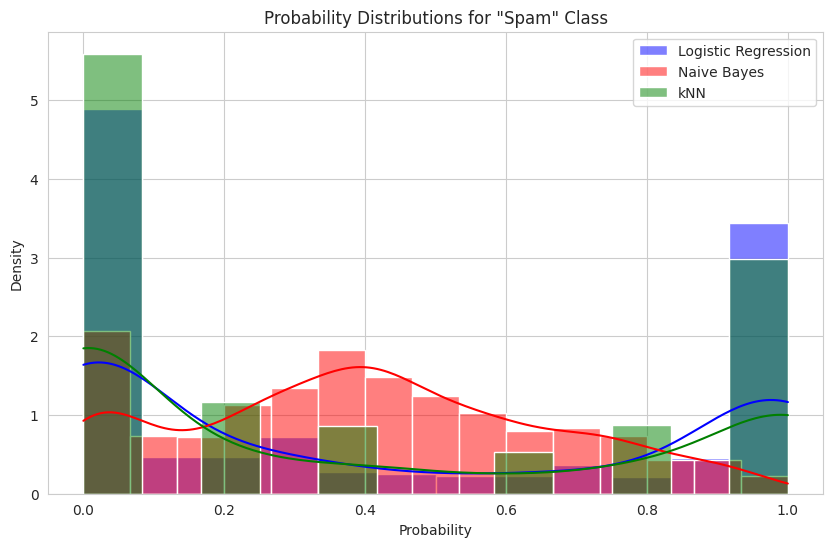

In [35]:
"""
Plot probabilities for the test data of being from "spam" class
How many modes (or ``peaks``) these distributions have?
"""

lr_probs = best_lr.predict_proba(x_test_scaled)[:, 1]
nb_probs = best_nb.predict_proba(x_test_scaled_NB)[:, 1]
knn_probs = best_knn.predict_proba(x_test_scaled)[:, 1]

plt.figure(figsize=(10, 6))
sns.histplot(lr_probs, kde=True, color='blue', label='Logistic Regression', stat='density')
sns.histplot(nb_probs, kde=True, color='red', label='Naive Bayes', stat='density')
sns.histplot(knn_probs, kde=True, color='green', label='kNN', stat='density')
plt.title('Probability Distributions for "Spam" Class')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()
plt.show()



In [36]:
from scipy.stats import mode

lr_modes = mode(lr_probs).count
nb_modes = mode(nb_probs).count
knn_modes = mode(knn_probs).count

print("Number of Modes (Peaks):")
print("Logistic Regression:", lr_modes)
print("Naive Bayes:", nb_modes)
print("kNN:", knn_modes)

Number of Modes (Peaks):
Logistic Regression: 16
Naive Bayes: 16
kNN: 536


In [37]:
"""
Show which classifier is the most overfitted according to development set (union of training and validation sets) and test set
Show which classifier is the least overfitted according to development set (union of training and validation sets) and test set
"""

lr_roc_auc_dev = roc_auc_score(y_dev, best_lr.predict_proba(x_train_scaled)[:, 1])
nb_roc_auc_dev = roc_auc_score(y_dev, best_nb.predict_proba(x_train_scaled_NB)[:, 1])
knn_roc_auc_dev = roc_auc_score(y_dev, best_knn.predict_proba(x_train_scaled)[:, 1])

lr_roc_auc_test = roc_auc_score(y_test, best_lr.predict_proba(x_test_scaled)[:, 1])
nb_roc_auc_test = roc_auc_score(y_test, best_nb.predict_proba(x_test_scaled_NB)[:, 1])
knn_roc_auc_test = roc_auc_score(y_test, best_knn.predict_proba(x_test_scaled)[:, 1])

# differences in ROC AUC between the test and dev sets
lr_overfitting = lr_roc_auc_test - lr_roc_auc_dev
nb_overfitting = nb_roc_auc_test - nb_roc_auc_dev
knn_overfitting = knn_roc_auc_test - knn_roc_auc_dev

print("Overfitting (Test set ROC AUC - Development set ROC AUC):")
print("Logistic Regression:", lr_overfitting)
print("Naive Bayes:", nb_overfitting)
print("kNN:", knn_overfitting)

most_overfitted_classifier = max([('Logistic Regression', lr_overfitting), ('Naive Bayes', nb_overfitting), ('kNN', knn_overfitting)], key=lambda x: x[1])
least_overfitted_classifier = min([('Logistic Regression', lr_overfitting), ('Naive Bayes', nb_overfitting), ('kNN', knn_overfitting)], key=lambda x: x[1])

print("\nMost Overfitted Classifier:", most_overfitted_classifier)
print("Least Overfitted Classifier:", least_overfitted_classifier)



Overfitting (Test set ROC AUC - Development set ROC AUC):
Logistic Regression: -0.005482812039124041
Naive Bayes: 0.0006481470513489684
kNN: -0.02347365429501891

Most Overfitted Classifier: ('Naive Bayes', 0.0006481470513489684)
Least Overfitted Classifier: ('kNN', -0.02347365429501891)


In [38]:
"""
Find 5 most and 5 least "spam" objects from the test data for every classifier.
Show which of them are matched and aren't matched.
"""
lr_probs = best_lr.predict_proba(x_test_scaled)[:, 1]
nb_probs = best_nb.predict_proba(x_test_scaled_NB)[:, 1]
knn_probs = best_knn.predict_proba(x_test_scaled)[:, 1]

prob_indices_lr = list(enumerate(lr_probs))
prob_indices_nb = list(enumerate(nb_probs))
prob_indices_knn = list(enumerate(knn_probs))

prob_indices_lr.sort(key=lambda x: x[1], reverse=True)
prob_indices_nb.sort(key=lambda x: x[1], reverse=True)
prob_indices_knn.sort(key=lambda x: x[1], reverse=True)

# indices of 5 most and 5 least "spam" objects
most_spam_indices_lr = [index for index, _ in prob_indices_lr[:5]]
least_spam_indices_lr = [index for index, _ in prob_indices_lr[-5:]]

most_spam_indices_nb = [index for index, _ in prob_indices_nb[:5]]
least_spam_indices_nb = [index for index, _ in prob_indices_nb[-5:]]

most_spam_indices_knn = [index for index, _ in prob_indices_knn[:5]]
least_spam_indices_knn = [index for index, _ in prob_indices_knn[-5:]]

#Show which of them are matched and aren't matched
matches_lr = set(most_spam_indices_lr).intersection(set(most_spam_indices_nb), set(most_spam_indices_knn))
mismatches_lr = set(most_spam_indices_lr).difference(set(most_spam_indices_nb), set(most_spam_indices_knn))

matches_least_lr = set(least_spam_indices_lr).intersection(set(least_spam_indices_nb), set(least_spam_indices_knn))
mismatches_least_lr = set(least_spam_indices_lr).difference(set(least_spam_indices_nb), set(least_spam_indices_knn))

print("Matches among 5 most spam objects:")
print("Indices:", matches_lr)
print("\nMatches among 5 least spam objects:")
print("Indices:", matches_least_lr)

print("\nMismatches among 5 most spam objects:")
print("Indices:", mismatches_lr)
print("\nMismatches among 5 least spam objects:")
print("Indices:", mismatches_least_lr)



Matches among 5 most spam objects:
Indices: set()

Matches among 5 least spam objects:
Indices: set()

Mismatches among 5 most spam objects:
Indices: {489, 275, 252, 1033}

Mismatches among 5 least spam objects:
Indices: {592, 1075, 933}


In [39]:
results_df = pd.DataFrame(columns=["Most_Spam_Indices", "Least_Spam_Indices"])

results_df.loc["LR"] = [most_spam_indices_lr, least_spam_indices_lr]
results_df.loc["NB"] = [most_spam_indices_nb, least_spam_indices_nb]
results_df.loc["kNN"] = [most_spam_indices_knn, least_spam_indices_knn]

print("DataFrame with 5 most and 5 least spam objects for every classifier:")
print(results_df)


DataFrame with 5 most and 5 least spam objects for every classifier:
              Most_Spam_Indices              Least_Spam_Indices
LR   [275, 489, 1033, 695, 252]      [933, 715, 884, 592, 1075]
NB    [695, 451, 447, 427, 785]       [753, 237, 856, 715, 884]
kNN           [3, 4, 9, 14, 15]  [1130, 1131, 1132, 1137, 1150]
